# Подход к отсеиванию некачественных фотографий

Первая проверка до детекции прутков: отсеиваем фотографии с сильным засветом и нечёткие изображения.

Вторая проверка после детекции: отсеиваем изображения, на которых
- прутков очень много
- их нет совсем
- прутки сфотографированы частично и находятся на краях фотографии.

Третья проверка (локальная) на выделенных детекцией bounding box-ах: отсеиваем
- сильный засвет
- нечёткость
- прутки малой площади
- прутки, слишком сильно повёрнутые относительно положения: изображение их торца не совпадает с поперечным сечением бруска 
- прутки, на которых невозможно распознать цифры

На всех проверках будем собирать отрицательные примеры, считать квантили для значений метрик на этих примерах. А затем отсеивать изображения по посчитанным квантилям

# Первая проверка до детекции

## Сильный засвет

В этом блоке решающей метрикой будет средняя яркость по изображению.

Нагенерируем отрицательные примеры при помощи аугментации:

In [1]:
import random
import os

import cv2
from matplotlib import pyplot as plt
import numpy as np

import albumentations as A

CURR_DIR = os.getcwd()

In [2]:
def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)

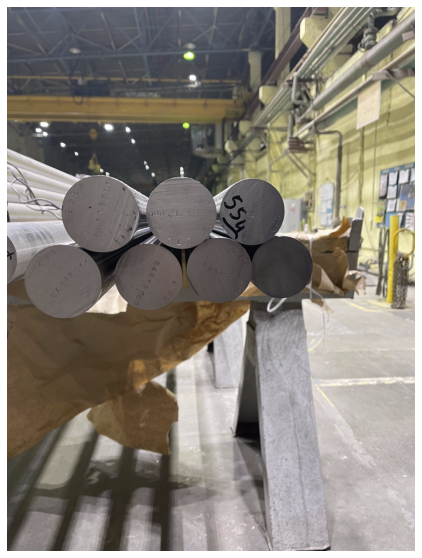

In [3]:
image = cv2.imread(os.path.join(CURR_DIR, 'img_examples/global_highlights/positive/IMG_1748.png'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image)

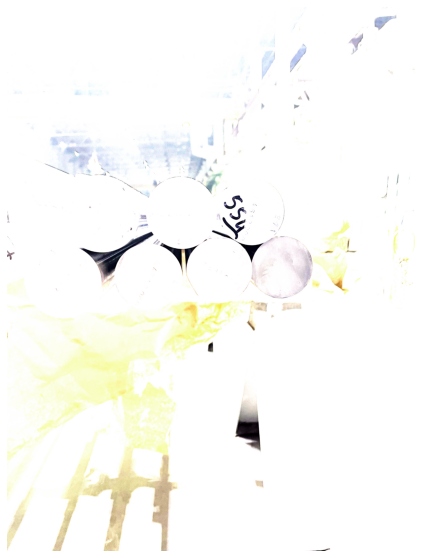

In [4]:
transform = A.ColorJitter(brightness=(5, 6))
random.seed(7)
augmented_image = transform(image=image)['image']
visualize(augmented_image)

In [5]:
from tqdm.notebook import tqdm

POS_PATH = os.path.join(CURR_DIR, 'img_examples/global_highlights/positive')
NEG_PATH = os.path.join(CURR_DIR, 'img_examples/global_highlights/negative')

for img in tqdm(os.listdir(POS_PATH)):
    curr_image = cv2.imread(os.path.join(POS_PATH, img))
    for i in [1, 3, 7]:
        random.seed(i)
        augmented_image = transform(image=curr_image)['image']
        cv2.imwrite(os.path.join(NEG_PATH, img + '_' + str(i)), augmented_image)

  0%|          | 0/71 [00:00<?, ?it/s]

Теперь посчитаем среднюю яркость на полученных "плохих" изображениях:

In [6]:
negative_intensities = np.zeros(len(os.listdir(NEG_PATH)))

for i, img in tqdm(enumerate(os.listdir(NEG_PATH))):
    image = cv2.imread(os.path.join(NEG_PATH, img))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    intensity = gray / 255
    mean_intensity = np.mean(intensity)
    negative_intensities[i] = mean_intensity
    
positive_intensities = np.zeros(len(os.listdir(POS_PATH)))

for i, img in tqdm(enumerate(os.listdir(POS_PATH))):
    image = cv2.imread(os.path.join(POS_PATH, img))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    intensity = gray / 255
    mean_intensity = np.mean(intensity)
    positive_intensities[i] = mean_intensity

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [7]:
def print_statistics(array):
    print('Min: %.3f, Max: %.3f' % (np.min(array), np.max(array)))
    print('Mean: %.3f' % np.mean(array))
    print('0.02-quantile: %.3f, median: %.3f, 0.98-quantile: %.3f' % (np.quantile(array, 0.02), np.quantile(array, 0.5), np.quantile(array, 0.98)))

In [8]:
print('Positive examples:')
print_statistics(positive_intensities)
print('Negative examples:')
print_statistics(negative_intensities)

Positive examples:
Min: 0.291, Max: 0.559
Mean: 0.479
0.02-quantile: 0.380, median: 0.480, 0.98-quantile: 0.550
Negative examples:
Min: 0.746, Max: 0.999
Mean: 0.951
0.02-quantile: 0.804, median: 0.964, 0.98-quantile: 0.999


Итоговая проверка будет выглядеть так:

In [9]:
def global_highlight(gray_img: np.ndarray) -> bool:
    "returns True, if image is too bright"
    
    intensity = gray_img / 255
    mean_intensity = np.mean(intensity)
    return mean_intensity > 0.804

## Нечёткость

В этой части нам могут помочь метрики, связанные с разбросом яркости, а именно выборочная дисперсия, STA6 (считает среднее по квадратам разностей между средней яркостью в окрестности и яркостью центрального в окрестности пикселя) и CONT (среднее по суммам разностей центрального пиксела и каждого из соседних пикселей).

Сначала вновь построим отрицательные примеры:

In [140]:
POS_PATH = os.path.join(CURR_DIR, 'img_examples/global_blurriness/positive')
NEG_PATH = os.path.join(CURR_DIR, 'img_examples/global_blurriness/negative')

Часть отберём из нашего датасета (4 фотографии)

А также добавим примеров с помощью аугментаций:

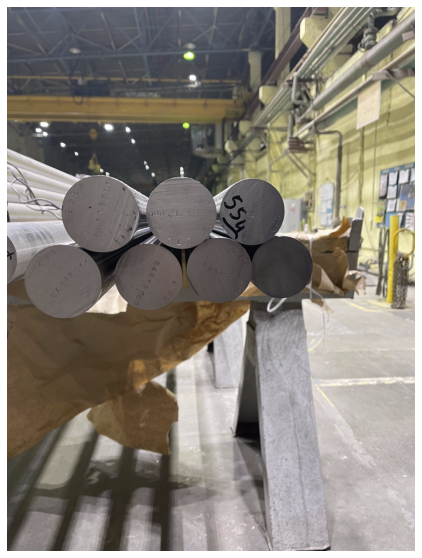

In [149]:
image = cv2.imread(os.path.join(CURR_DIR, 'img_examples/global_blurriness/positive/IMG_1748.png'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image)

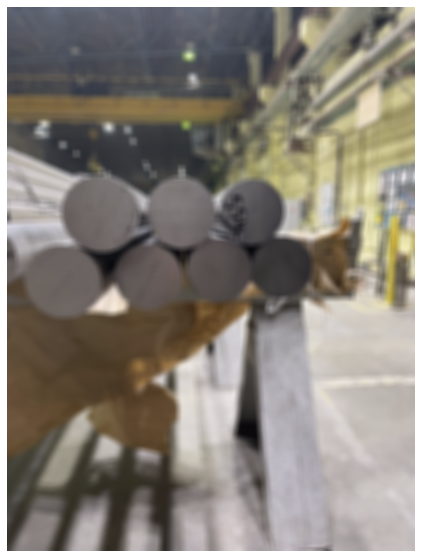

In [156]:
transform = A.Blur(blur_limit=(51, 301), p=1.0)
random.seed(42)
augmented_image = transform(image=image)['image']
visualize(augmented_image)

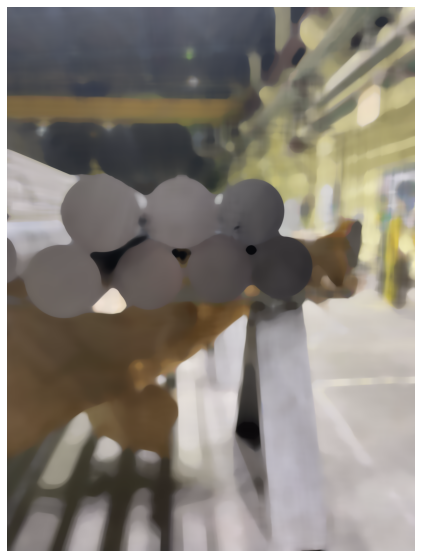

In [157]:
transform1 = A.MedianBlur(blur_limit=(51, 301), p=1.0)
random.seed(7)
augmented_image = transform1(image=image)['image']
visualize(augmented_image)

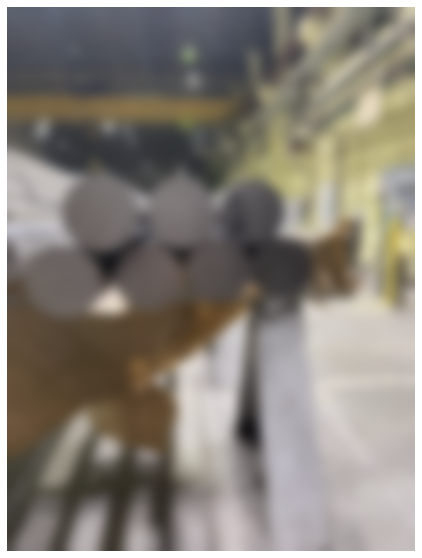

In [158]:
transform2 = A.GaussianBlur(blur_limit=(51, 301), p=1.0)
random.seed(7)
augmented_image = transform2(image=image)['image']
visualize(augmented_image)

In [159]:
blur_transforms = [transform, transform1, transform2]

In [160]:
for img in tqdm(os.listdir(POS_PATH)):
    curr_image = cv2.imread(os.path.join(POS_PATH, img))
    img_name = img.replace('.png', '').replace('.jpg', '')
    for i, transform_func in enumerate(blur_transforms):
        random.seed(i)
        augmented_image = transform_func(image=curr_image)['image']
        cv2.imwrite(os.path.join(NEG_PATH, img_name + '_' + str(i) + '.png'), augmented_image)

  0%|          | 0/67 [00:00<?, ?it/s]

In [172]:
import scipy.ndimage as snd

def sta6_optimized(gray_img: np.ndarray, conv_size: int = 0, stride: int = 1):
    image_intensity = gray_img / 255
    
    mean_kernel = np.ones((conv_size, conv_size)) / conv_size**2
    image_mean_intensity = snd.convolve(image_intensity, mean_kernel)
    image_mean_intensity = image_mean_intensity[(conv_size-1)//2:image_mean_intensity.shape[0]-conv_size//2, (conv_size-1)//2:image_mean_intensity.shape[1]-conv_size//2]
    image_intensity = image_intensity[(conv_size-1)//2:image_intensity.shape[0]-conv_size//2, (conv_size-1)//2:image_intensity.shape[1]-conv_size//2]

    image_intensity = image_intensity[::stride, ::stride]
    image_mean_intensity = image_mean_intensity[::stride, ::stride]
    
    sta6 = np.mean(np.power(image_intensity - image_mean_intensity, 2))

    return sta6

In [173]:
def count_sta6_on_images(path_to_images):
    values = []
    for i, img in tqdm(enumerate(os.listdir(path_to_images))):
        image = cv2.imread(os.path.join(path_to_images, img))
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        curr_val = sta6_optimized(gray, conv_size=5)
        values.append(curr_val)
    return np.array(values)

negative_sta6 = count_sta6_on_images(NEG_PATH)
positive_sta6 = count_sta6_on_images(POS_PATH)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [174]:
print('Positive examples: STA6 * 10^7')
print_statistics(positive_sta6 * 1e7)
print('Negative examples: STA6 * 10^7')
print_statistics(negative_sta6 * 1e7)

Positive examples: STA6 * 10^7
Min: 838.886, Max: 7261.095
Mean: 2315.499
0.02-quantile: 904.191, median: 1766.366, 0.98-quantile: 7059.535
Negative examples: STA6 * 10^7
Min: 3.858, Max: 2727.212
Mean: 44.616
0.02-quantile: 4.546, median: 9.273, 0.98-quantile: 35.992


In [175]:
def sample_variance(gray_img: np.ndarray):
    return np.var(gray_img)

In [176]:
def count_metric_on_images(metric, path_to_images):
    values = []
    for i, img in tqdm(enumerate(os.listdir(path_to_images))):
        image = cv2.imread(os.path.join(path_to_images, img))
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        curr_val = metric(gray)
        values.append(curr_val)
    return np.array(values)

In [177]:
negative_var = count_metric_on_images(sample_variance, NEG_PATH)
positive_var = count_metric_on_images(sample_variance, POS_PATH)

print('Positive examples: variance')
print_statistics(positive_var)
print('Negative examples: variance')
print_statistics(negative_var)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Positive examples: variance
Min: 1151.716, Max: 4925.156
Mean: 2933.722
0.02-quantile: 1343.125, median: 2944.202, 0.98-quantile: 4677.895
Negative examples: variance
Min: 838.329, Max: 5049.581
Mean: 2246.935
0.02-quantile: 963.502, median: 2243.093, 0.98-quantile: 4063.109


In [178]:
from scipy.ndimage import convolve

def CONT(gray_img: np.ndarray):
    intensity = gray_img / 255
    kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    return np.mean(convolve(intensity, kernel)[1:-1, 1:-1])

In [179]:
negative_cont = count_metric_on_images(CONT, NEG_PATH)
positive_cont = count_metric_on_images(CONT, POS_PATH)

print('Positive examples: CONT')
print_statistics(positive_cont)
print('Negative examples: CONT')
print_statistics(negative_cont)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Positive examples: CONT
Min: 0.291, Max: 0.559
Mean: 0.479
0.02-quantile: 0.380, median: 0.483, 0.98-quantile: 0.551
Negative examples: CONT
Min: 0.287, Max: 0.568
Mean: 0.480
0.02-quantile: 0.379, median: 0.483, 0.98-quantile: 0.554


Видимо, CONT не очень информативная метрика на данном этапе...

Будем отсеивать нечёткие изображения по STA6:

In [182]:
def global_too_blurry(gray_img: np.ndarray) -> bool:
    "returns True, if image is too blurry"
    return sta6_optimized(gray_img, conv_size=5) * 1e7 <= 35.992

# Вторая проверка после детекции

Первым делом научимся запускать нашу сохранённую модель детекции (yolov5) на входной фотографии:

Достаточно в папке с yolov5 запустить команду "python3 detect.py --weights rod_detection_best.pt --img 1080 --conf-thres 0.7 --source data/img --save-txt"

## Прутки на краях изображения

Имеются в виду такие картинки:

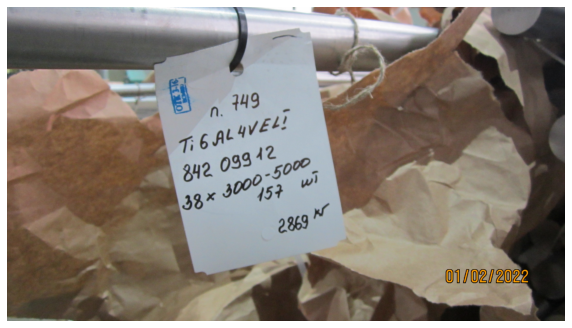

In [74]:
POS_PATH = os.path.join(CURR_DIR, 'img_examples/rods_on_periphery/positive')
NEG_PATH = os.path.join(CURR_DIR, 'img_examples/rods_on_periphery/negative')

image = cv2.imread(os.path.join(NEG_PATH, 'IMG_6409.jpg'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image)

Чтобы получить дополнительные отрицательные примеры, будем брать от изображений только "рамочку" разной ширины.

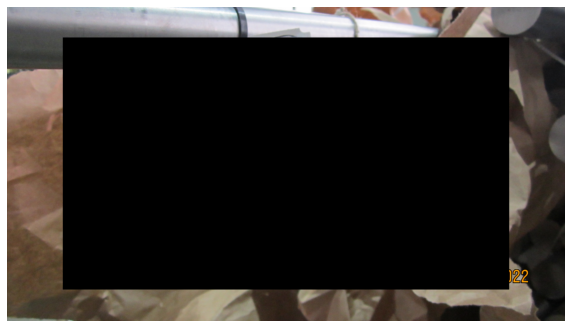

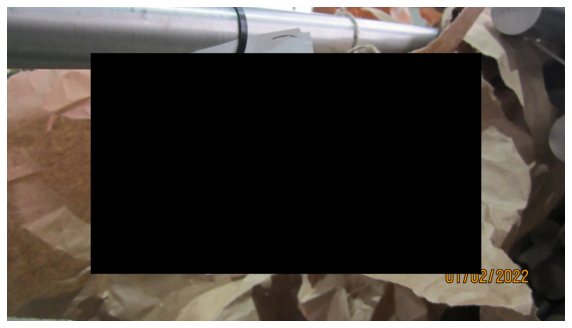

In [83]:
def get_image_frame(image: np.ndarray, frame_ratio: float):
    height, width, _ = image.shape
    x1, x2 = int(height * frame_ratio), height - int(height * frame_ratio)
    y1, y2 = int(width * frame_ratio), width - int(width * frame_ratio)
    central_pixels = np.zeros(image.shape)
    central_pixels[x1:x2, y1:y2,:] = image[x1:x2, y1:y2,:]
    return np.array(image - central_pixels, dtype=int)
    
visualize(get_image_frame(image, 0.1))
visualize(get_image_frame(image, 0.15))

In [124]:
frame_ratios = [0.05, 0.06, 0.07]

for img in tqdm(os.listdir(POS_PATH)):
    curr_image = cv2.imread(os.path.join(POS_PATH, img))
    img_name = img.replace('.png', '').replace('.jpg', '')
    for i, ratio in enumerate(frame_ratios):
        frame = get_image_frame(curr_image, ratio)
        cv2.imwrite(os.path.join(NEG_PATH, img_name + '_' + str(i) + '.png'), frame)

  0%|          | 0/70 [00:00<?, ?it/s]

Теперь запустим модель детекции на полученных и исходных изображениях (консольной командой). Предсказания сохраняются в виде размеченных картинок и текстовых файлов с координатами bounding box-ов. И будем обрабатывать результаты.

Посмотрим на пример:

In [86]:
DETECTED_POS = '/home/asya/yolov5/runs/detect/exp'
DETECTED_NEG = '/home/asya/yolov5/runs/detect/exp2'

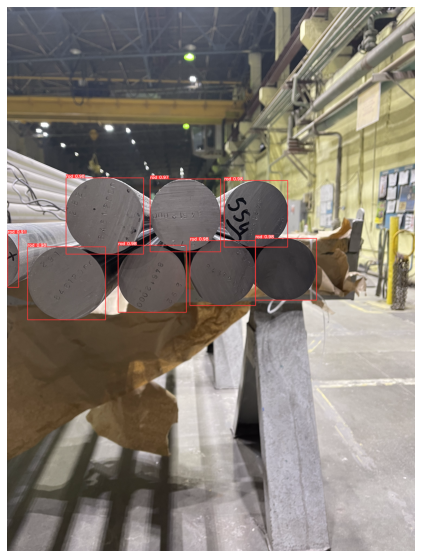

In [88]:
pos_image = cv2.imread(os.path.join(DETECTED_POS, 'IMG_1749.png'))
pos_image = cv2.cvtColor(pos_image, cv2.COLOR_BGR2RGB)
visualize(pos_image)

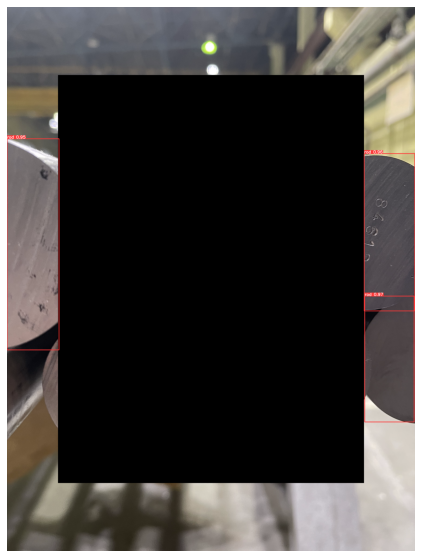

In [90]:
neg_image = cv2.imread(os.path.join(DETECTED_NEG, 'IMG_1750_1.png'))
neg_image = cv2.cvtColor(neg_image, cv2.COLOR_BGR2RGB)
visualize(neg_image)

Идея метрики на данном этапе: посчитать взвешенную сумму по пикселям выделенных прутков, причём сделать так, чтобы выполнялось условие "чем ближе пиксели к центру, тем больше веса". В качестве весов для фиксированного прутка возьмём косинус расстояния от его центра до центрального пикселя картинки

In [126]:
def weight_rod_pixels_sum(txt_file_path):
    ans_sum = 0
    with open(txt_file_path, 'r') as f:
        for line in f.readlines():
            arr = [float(s) for s in line.split()[1:]]
            x_center, y_center, width, height = arr
            dist = np.sqrt((x_center - 0.5) ** 2 + (y_center - 0.5) ** 2)
            ans_sum += np.cos(dist) * width * height
    return ans_sum

In [127]:
def count_weight_sums_on_txt_files(labels_path):
    values = []
    for txt_file in tqdm(os.listdir(labels_path)):
        txt_file_path = os.path.join(labels_path, txt_file)
        values.append(weight_rod_pixels_sum(txt_file_path))
    return np.array(values)

In [128]:
DETECTED_POS_LABELS = '/home/asya/yolov5/runs/detect/exp/labels'
DETECTED_NEG_LABELS = '/home/asya/yolov5/runs/detect/exp2/labels'

negative_weight_sums = count_weight_sums_on_txt_files(DETECTED_NEG_LABELS)
positive_weight_sums = count_weight_sums_on_txt_files(DETECTED_POS_LABELS)

print('Positive examples:')
print_statistics(positive_weight_sums)
print('Negative examples:')
print_statistics(negative_weight_sums)

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Positive examples:
Min: 0.066, Max: 0.967
Mean: 0.436
0.02-quantile: 0.103, median: 0.392, 0.98-quantile: 0.919
Negative examples:
Min: 0.002, Max: 0.959
Mean: 0.040
0.02-quantile: 0.002, median: 0.022, 0.98-quantile: 0.094


In [129]:
def global_rods_on_periphery(txt_file_path) -> bool:
    "returns True, if rods are on the image periphery"
    return weight_rod_pixels_sum(txt_file_path) < 0.094

## Прутков вообще нет

In [130]:
def global_without_rods(txt_file_path) -> bool:
    "returns True, if our image has 0 rods"
    with open(txt_file_path, 'r') as f:
        return (len(f.readlines()) == 0)

## Прутков слишком много

In [131]:
def global_too_many_rods(txt_file_path) -> bool:
    "returns True, if our image has too many rods"
    with open(txt_file_path, 'r') as f:
        return (len(f.readlines()) >= 30)